# Potato Disease Prediction 

## Importing Libraries

In [58]:
# importing tensor flow
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
print("Libraries Imported Successfully")

Libraries Imported Successfully


### Variables used in Code

In [2]:
# Variables that we will use in the code
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

### Loading TF dataset using data processing

In [3]:
# Loading images 
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
print("data loaded")

Found 2152 files belonging to 3 classes.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

data loaded


### Class Names of Potatos

In [4]:
class_names = dataset.class_names

In [5]:
# printing the Names of Classes
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

#### The length of Dataset is 68 because we created Batch of 32 size (32*68 = 2176)

In [7]:
# Printing the size of batch
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


2023-04-05 13:41:40.109835: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


#### Here 32 is Batch Size, 256X256 is Image size and 3 is RGB 0 1 2 are three classes early blight , late blight and healthy

## Visualisation of Dataset

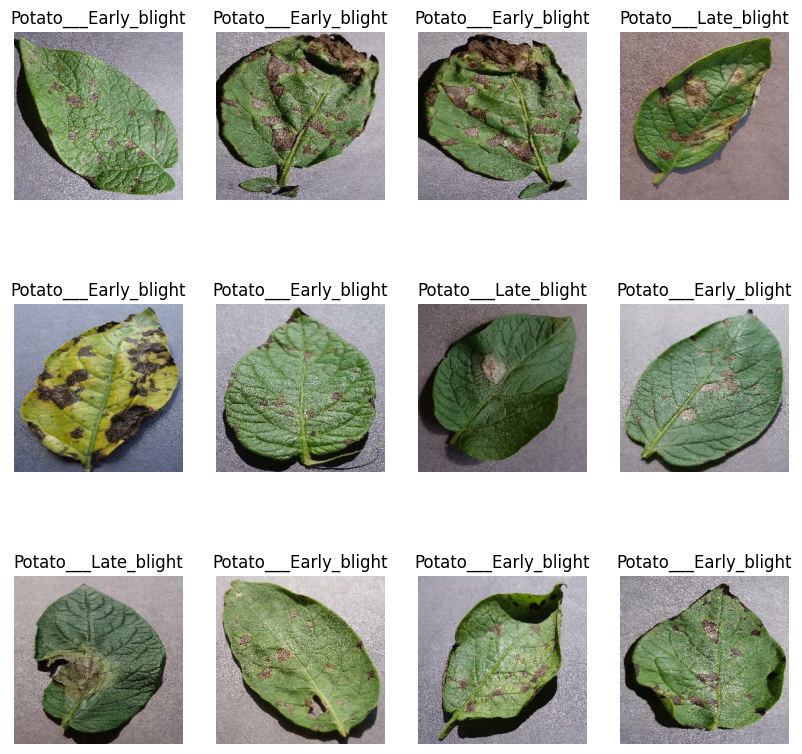

In [8]:
# Printing Image
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) # unint because it is in float 
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Splitting dataset in to Train and Test

In [9]:
train_size = 0.8 # 80%
len(dataset)*train_size

54.400000000000006

In [10]:
## Train and split is not available in Tensorflow so we use takt
# Train Dataset
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
# Test Dataset
test_ds = dataset.skip(54) # after 54 percent of data 
len(test_ds)

14

In [12]:
val_size = 0.1 # 10%
len(dataset)*val_size

6.800000000000001

In [13]:
# Validation Dataset
val_ds = test_ds.take(6) # taking from Test Dataset
len(val_ds)

6

In [14]:
# Actual Test Dataset
test_ds = test_ds.skip(6)
len(test_ds)

8

## Creating a Function for splitting Dataset

In [16]:
# function to make partition of dataset
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

### Calling function to make train,test and valid dataset

In [17]:
# calling function
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print("Success")

Success


In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

### Caching of Dataset
It Increases the speed of Pipeline by making Cache of Images

### Cache, Shuffle, and Prefetch the Dataset

In [21]:
# Caching
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
print("Success")

Success


#### We done caching and prefetching so the traing speed increases

### Resizing and Rescaling our Images Dataset

## Building the Model
### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

Why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])
print("Success")

Success


### Data Augmentation
It will create multiple Images of Test Image to increase the performance of Model

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])
print("Success")

Success


## CNN (Convolution Neural Network)

#### Model
Neural Network Architechture

In [24]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
print("Success")

Success


In [25]:
# Summary Of Model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compile and optimize
We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

## Training Model

In [40]:
# Training the Model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)


Epoch 1/50
54/54 [==============================] - 14s 251ms/step - loss: 0.0125 - accuracy: 0.9965 - val_loss: 0.0476 - val_accuracy: 0.9896
Epoch 2/50
54/54 [==============================] - 11s 210ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0304 - val_accuracy: 0.9844
Epoch 3/50
54/54 [==============================] - 11s 210ms/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0392 - val_accuracy: 0.9844
Epoch 4/50
54/54 [==============================] - 11s 209ms/step - loss: 0.1301 - accuracy: 0.9531 - val_loss: 0.1590 - val_accuracy: 0.9427
Epoch 5/50
54/54 [==============================] - 11s 208ms/step - loss: 0.0404 - accuracy: 0.9861 - val_loss: 0.0437 - val_accuracy: 0.9792
Epoch 6/50
54/54 [==============================] - 11s 209ms/step - loss: 0.0766 - accuracy: 0.9699 - val_loss: 0.0659 - val_accuracy: 0.9844
Epoch 7/50
54/54 [==============================] - 11s 211ms/step - loss: 0.0147 - accuracy: 0.9948 - val_loss: 0.0338 - val_accuracy: 0.9948

### Scores of Model

In [41]:
scores = model.evaluate(test_ds) 

8/8 [==============================] - 1s 132ms/step - loss: 0.0555 - accuracy: 0.9961


In [42]:
scores

[0.055498916655778885, 0.99609375]

In [43]:
history

In [44]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [45]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [46]:
len(history.history['accuracy'])

50

In [34]:
history.history['accuracy']

[0.5590277910232544,
 0.7662037014961243,
 0.8819444179534912,
 0.8998842835426331,
 0.9259259104728699,
 0.9288194179534912,
 0.9681712985038757,
 0.9652777910232544,
 0.9791666865348816,
 0.9542824029922485,
 0.9762731194496155,
 0.9814814925193787,
 0.9913194179534912,
 0.9895833134651184,
 0.9971064925193787,
 0.9901620149612427,
 0.9699074029922485,
 0.9866898059844971,
 0.9965277910232544,
 1.0]

### Visualize the History

### Plotting Graph

In [47]:
# Variables
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

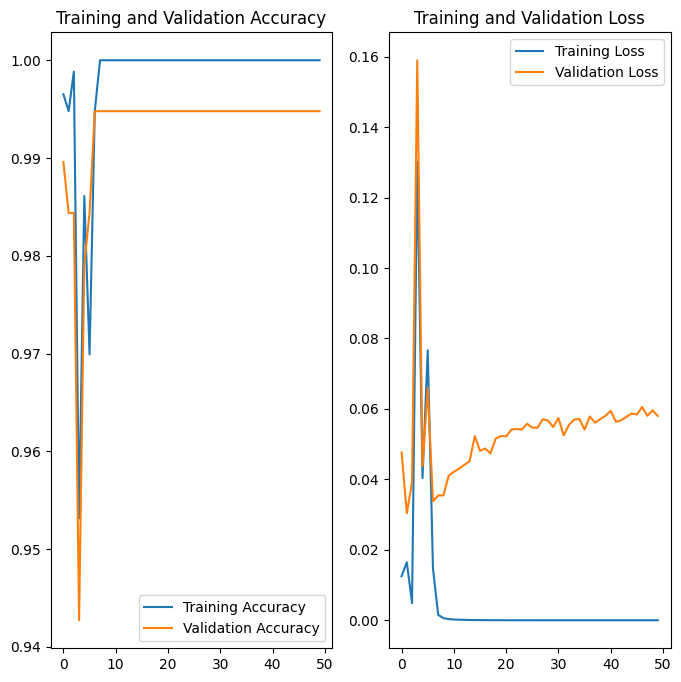

In [48]:
# Graph
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Running Prediction on Sample Images

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 251ms/step
predicted label: Potato___Early_blight


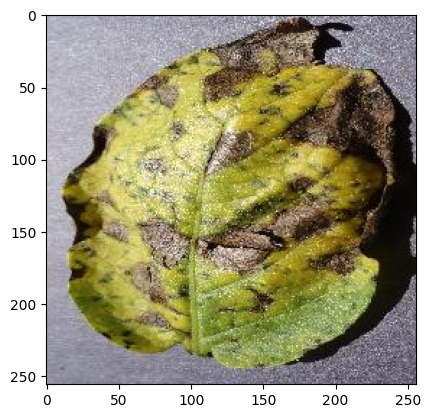

In [49]:
# Prediction
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

## Creating a function for prediction

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a Image

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

#### Calling Function

1/1 [==============================] - 0s 16ms/step


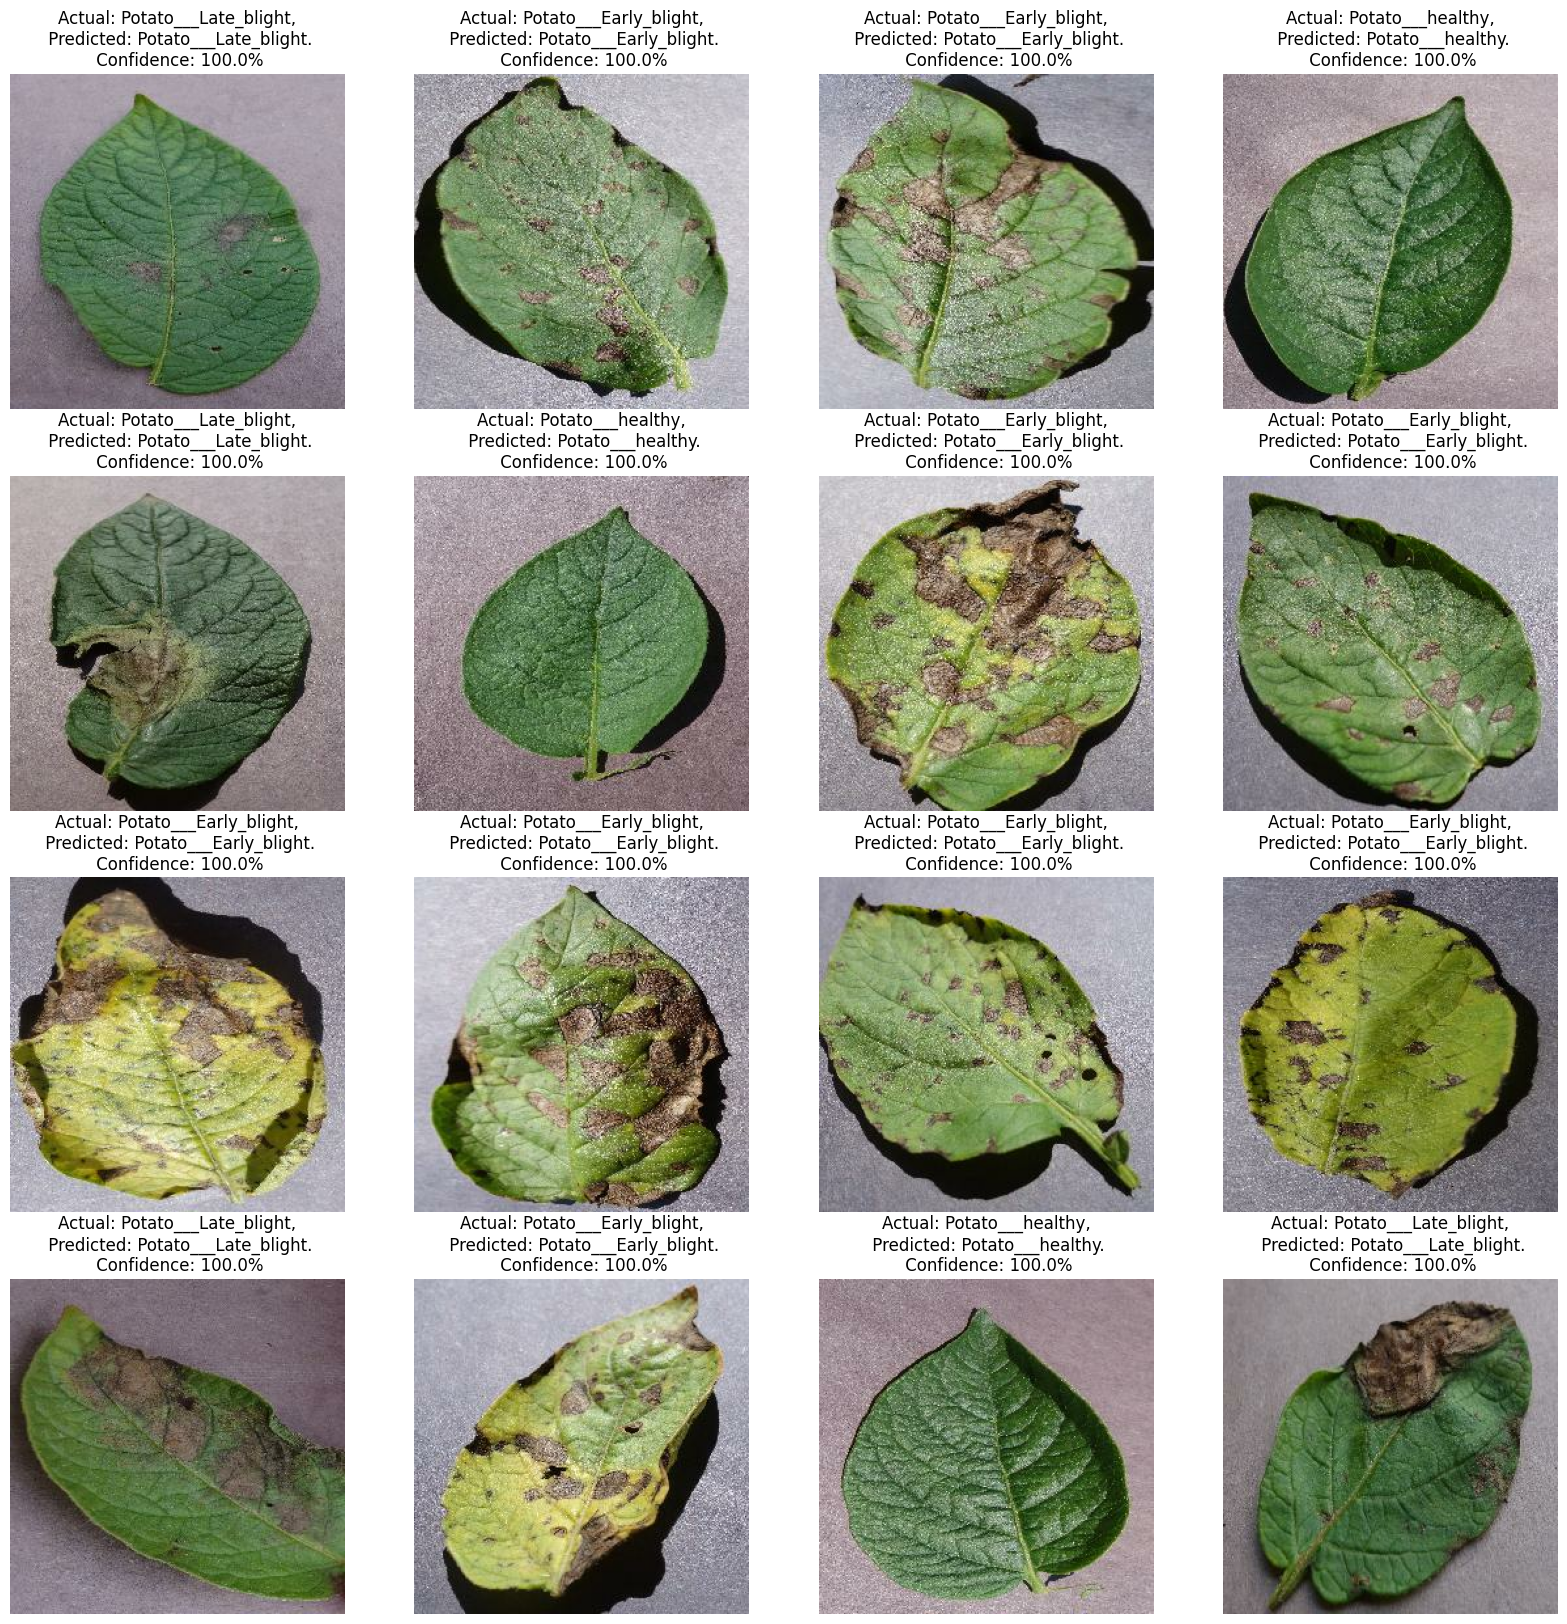

In [51]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving Model

In [52]:
model_version=1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../saved_models/1/assets


INFO:tensorflow:Assets written to: ../saved_models/1/assets


In [53]:
model_version= 2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets


### Auto Incremented Model using os.listdir

In [54]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3/assets


INFO:tensorflow:Assets written to: ../models/3/assets


In [55]:
print("Hello")

Hello


In [70]:
model.save("../potatoes.h5")

In [56]:
model.save("../potatoes.h5")

In [60]:
import keras

In [61]:
# Testing Model
# import
new_model = keras.models.load_model('../potatoes.h5')

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 0s 187ms/step
predicted label: Potato___Late_blight


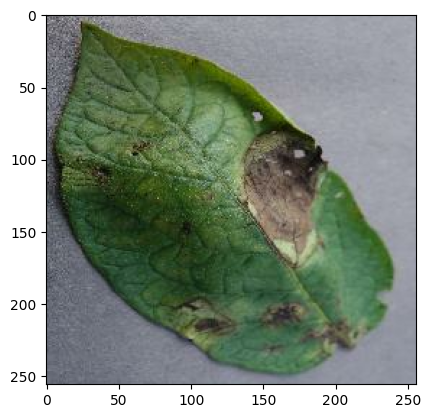

In [62]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = new_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])